In [97]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModel
from transformers.models.mpnet.modeling_mpnet import create_position_ids_from_input_ids

from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

In [2]:
model_name = 'all-mpnet-base-v2'

# Word embeddings

The sentence_transformers library uses HuggingFace's transformers library under the hood. That means we can have access to the token embeddings from

## Tokenization

Reference: https://huggingface.co/docs/transformers/tokenizer_summary

In [4]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/" + model_name)
type(tokenizer)

transformers.models.mpnet.tokenization_mpnet_fast.MPNetTokenizerFast

In [8]:
len(tokenizer.get_vocab())

30527

In [9]:
words = ["apple", "Apple", "do", "don't", "surprisingly", "annoyingly", "CPU", "GPU", "transformers"]
for ww in words:
    print(f"{ww}: {tokenizer.tokenize(ww)}")

apple: ['apple']
Apple: ['apple']
do: ['do']
don't: ['don', "'", 't']
surprisingly: ['surprisingly']
annoyingly: ['annoying', '##ly']
CPU: ['cpu']
GPU: ['gp', '##u']
transformers: ['transformers']


In [10]:
tokenizer.tokenize("Question: How can I get involved in an IPO that Morgan Stanley is underwriting?")

['question',
 ':',
 'how',
 'can',
 'i',
 'get',
 'involved',
 'in',
 'an',
 'ip',
 '##o',
 'that',
 'morgan',
 'stanley',
 'is',
 'under',
 '##writing',
 '?']

In [11]:
tokenizer.tokenize("We are accounted poor citizens, the patricians good. What authority surfeits on would relieve us:")

['we',
 'are',
 'accounted',
 'poor',
 'citizens',
 ',',
 'the',
 'patricia',
 '##ns',
 'good',
 '.',
 'what',
 'authority',
 'surf',
 '##eit',
 '##s',
 'on',
 'would',
 'relieve',
 'us',
 ':']

In [13]:
[w for w in tokenizer.get_vocab().keys() if w.startswith("bank")]

['banking', 'bankrupt', 'banker', 'bankers', 'bankruptcy', 'bank', 'banks']

## Token embeddings

In [3]:
# Set argument output_hidden_states to True if you want to get intermediate representations
model = AutoModel.from_pretrained("sentence-transformers/" + model_name, output_hidden_states=True)
type(model)

transformers.models.mpnet.modeling_mpnet.MPNetModel

In [5]:
# Max context length is 514 (see dim of position_embeddings
type(model.embeddings)

transformers.models.mpnet.modeling_mpnet.MPNetEmbeddings

In [83]:
model.embeddings

MPNetEmbeddings(
  (word_embeddings): Embedding(30527, 768, padding_idx=1)
  (position_embeddings): Embedding(514, 768, padding_idx=1)
  (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [6]:
model.embeddings.LayerNorm, model.embeddings.dropout

(LayerNorm((768,), eps=1e-05, elementwise_affine=True),
 Dropout(p=0.1, inplace=False))

In [7]:
model.training

False

### Decompose steps in embedding layer

In [46]:
word = "apple"
word_tokenized = tokenizer(word, padding=True, truncation=True, max_length=128, return_tensors='pt')
word_tokenized

{'input_ids': tensor([[   0, 6211,    2]]), 'attention_mask': tensor([[1, 1, 1]])}

In [76]:
model.embeddings.LayerNorm.weight.shape, model.embeddings.LayerNorm.bias.shape, model.embeddings.LayerNorm

(torch.Size([768]),
 torch.Size([768]),
 LayerNorm((768,), eps=1e-05, elementwise_affine=True))

In [73]:
word_embedding = model.embeddings.word_embeddings(word_tokenized["input_ids"])
word_embedding[0, 1, :20]

tensor([-0.0047,  0.0803,  0.1751, -0.0465, -0.0326,  0.0616,  0.0833, -0.1099,
         0.0376,  0.0033,  0.0017,  0.1452, -0.0827, -0.1474, -0.0634, -0.0544,
        -0.0448, -0.0013,  0.0403,  0.1619], grad_fn=<SliceBackward0>)

In [100]:
emb_idx = create_position_ids_from_input_ids(word_tokenized["input_ids"], 1)
emb_idx

tensor([[2, 3, 4]])

In [112]:
pos_emb = model.embeddings.position_embeddings(emb_idx)
pos_emb[0, 1, :20]

tensor([ 0.0481,  0.0504,  0.0340,  0.0078, -0.0005, -0.0213,  0.0243, -0.0567,
        -0.0059,  0.0313, -0.0165,  0.0280,  0.0585,  0.0019, -0.0103,  0.0222,
        -0.0103, -0.0005,  0.0061,  0.0030], grad_fn=<SliceBackward0>)

In [134]:
embedding = (word_embedding + pos_emb)
embedding[0, 1, :20]

tensor([ 0.0435,  0.1307,  0.2090, -0.0387, -0.0330,  0.0403,  0.1075, -0.1666,
         0.0317,  0.0346, -0.0148,  0.1732, -0.0242, -0.1455, -0.0738, -0.0322,
        -0.0551, -0.0018,  0.0464,  0.1649], grad_fn=<SliceBackward0>)

In [135]:
_tmp = embedding[0, 1, :]
((_tmp - _tmp.mean()) / (_tmp.var(unbiased=False) + 1e-5).sqrt() * model.embeddings.LayerNorm.weight + model.embeddings.LayerNorm.bias)[:20]

tensor([ 0.1175,  0.5071,  0.6669, -0.0728, -0.0922,  0.1441,  0.3902, -0.1599,
         0.1719,  0.0905, -0.0904,  0.6347, -0.0895, -0.5575, -0.2077, -0.1272,
        -0.0607, -0.0038,  0.2091,  0.4943], grad_fn=<SliceBackward0>)

In [108]:
model.embeddings.LayerNorm(_tmp)[:20]

tensor([ 0.1175,  0.5071,  0.6669, -0.0728, -0.0922,  0.1441,  0.3902, -0.1599,
         0.1719,  0.0905, -0.0904,  0.6347, -0.0895, -0.5575, -0.2077, -0.1272,
        -0.0607, -0.0038,  0.2091,  0.4943], grad_fn=<SliceBackward0>)

In [133]:
embedding_layernorm = model.embeddings.forward(word_tokenized["input_ids"])
embedding_layernorm[0, 1, :20]

tensor([ 0.1175,  0.5071,  0.6669, -0.0728, -0.0922,  0.1441,  0.3902, -0.1599,
         0.1719,  0.0905, -0.0904,  0.6347, -0.0895, -0.5575, -0.2077, -0.1272,
        -0.0607, -0.0038,  0.2091,  0.4943], grad_fn=<SliceBackward0>)

In [132]:
pos_emb.norm(dim=2), word_embedding.norm(dim=2), word_embedding_layernorm.norm(dim=2)

(tensor([[5.9215, 1.0328, 1.0007]], grad_fn=<LinalgVectorNormBackward0>),
 tensor([[4.7150, 2.3733, 2.5478]], grad_fn=<LinalgVectorNormBackward0>),
 tensor([[3.0357, 8.0590, 2.7213]], grad_fn=<LinalgVectorNormBackward0>))

### Look at how embeddings change through hidden layers

### Look at how embeddings change with context

### Look at whether embeddings are clustered by semantic

# Sentence embeddings

## Using library sentence_transformers

Example from: https://www.pinecone.io/learn/dense-vector-embeddings-nlp/#generating-dense-vectors

In [15]:
sentence_model = SentenceTransformer(model_name)

In [16]:
sentence_model.max_seq_length

384

In [18]:
sentences = [
    "it caught him off guard that space smelled of seared steak",
    "she could not decide between painting her teeth or brushing her nails",
    "he thought there'd be sufficient time is he hid his watch",
    "the bees decided to have a mutiny against their queen",
    "the sign said there was road work ahead so she decided to speed up",
    "on a scale of one to ten, what's your favorite flavor of color?",
    "flying stinging insects rebelled in opposition to the matriarch"
]

In [20]:
embeddings = sentence_model.encode(sentences)
embeddings.shape, type(embeddings)

((7, 768), numpy.ndarray)

In [19]:
np.linalg.norm(embeddings, axis=1)

array([0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99999994], dtype=float32)

In [8]:
type(model)

sentence_transformers.SentenceTransformer.SentenceTransformer

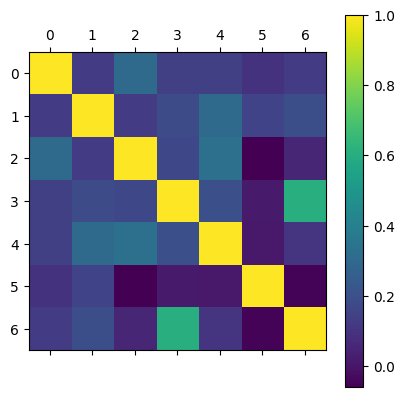

In [17]:
fig = plt.matshow(np.dot(embeddings, embeddings.T))
plt.colorbar()

In [23]:
cos_sim(embeddings[3,:], embeddings[6,:]), np.dot(embeddings[3,:], embeddings[6,:])

(tensor([[0.6084]]), 0.6083548)

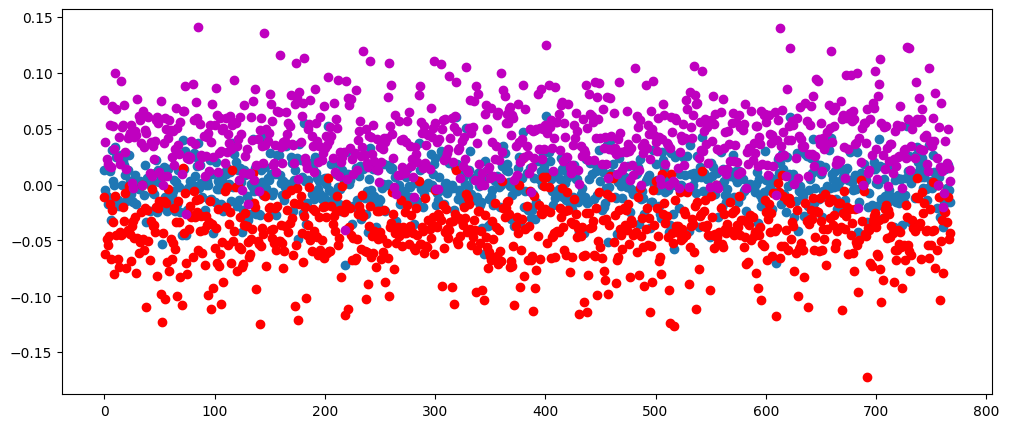

In [32]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.plot(embeddings.mean(axis=0), 'o')
ax.plot(embeddings.min(axis=0), 'or')
ax.plot(embeddings.max(axis=0), 'om')

In [37]:
np.median(embeddings.min(axis=0)), np.median(embeddings.mean(axis=0)), np.median(embeddings.max(axis=0))

(-0.04089734, 7.5658056e-05, 0.04107123)